# Compare Diligence Estimates

Simulate multiple models of students with varying noise and compare diligence estimates with each

## Setup

In [1]:
import sys
sys.path.append("../lib")

In [2]:
import math
import random
import uuid
import os
import copy
import itertools
from collections.abc import Iterable
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import FactorAnalysis

from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

import statsmodels.api as sm



In [3]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [4]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [5]:
# from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

In [6]:
from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.cognition import *
from learner.decider import *

In [7]:
from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import *

In [8]:
from analytics.student_stats import *
from analytics.cae import *
from analytics.featurization import *
from analytics.batch import *

In [9]:
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper
from log_db.learner_mapper import DBLearnerMapper

In [10]:
from CanonicalAutocorrelationAnalysis.model.caa import CAAComputation
from CanonicalAutocorrelationAnalysis.model.caaObject import *
from CanonicalAutocorrelationAnalysis.model.utils import l1Norm, l2Norm, r2Compute

In [11]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.info("Base directory for the project:\n%s" % base_dir)

INFO:analytics.batch:Base directory for the project:
/rdata/Sandbox/MotivSim


In [12]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:analytics.batch:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-96709ec6-2740-4d16-a811-29ee13b6bae0
INFO:analytics.batch:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [13]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 0 documents
INFO:log_db.mongo:collection name, caa_batches, has 0 documents
INFO:log_db.mongo:collection name, simbatches, has 0 documents
INFO:log_db.mongo:collection name, sessions, has 0 documents
INFO:log_db.mongo:collection name, caa_models, has 0 documents
INFO:log_db.mongo:collection name, domains, has 0 documents
INFO:log_db.mongo:collection name, students, has 0 documents
INFO:log_db.mongo:collection name, units, has 0 documents
INFO:log_db.mongo:collection name, decisions, has 0 documents
INFO:log_db.mongo:collection name, curriculums, has 0 documents
INFO:log_db.mongo:collection name, steps, has 0 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 0 documents
INFO:log_db.mongo:collection name, problems, has 0 documents
INFO:log_db.mongo:collection name, actions, has 0 documents
INFO:log_db.mongo:collection name, sections, has 0 documents
INFO:log_db.mongo:collection name, tutor_events, has 0 documents
INFO:log_db.mo

In [14]:
clear_db = True
if clear_db:
    logger.info("Clearing database before starting new simulation")
    db_util.clear_db()
else:
    logger.info("Skipping Clearing database")

INFO:analytics.batch:Clearing database before starting new simulation


## 1. Simulating learners

In [15]:
num_students = 200

In [16]:
def get_cog_params():
    ability = -2
    while (ability < -1) or (ability > 1):
        ability = np.random.normal(0, 0.6)
    return {"ability": ability}

def gen_students(num_students, domain, curric, 
                 cog_mod, cog_params, dec_mod, dec_params):
    stus = []
    for i in range(num_students):
        cp = cog_params()
        cog = cog_mod(domain, **cp)
        dp = dec_params()
        dec = dec_mod(**dp)
        decider = DiligentDecider(dec)
        stu = ModularLearner(domain, cog, decider)
        stus.append(stu)
        
    return stus

def simulate_students(curric, students, batch):    
    
    env = simpy.Environment()

    mastery_thres = 0.9
    m_ses_len = 40
    sd_ses_len = 8
    max_ses_len = 60
    sim_start = dt.datetime.now()

    mod = round(len(students) / 10)
    for i, stu in enumerate(students):
        if i % mod == 0:
            logger.info("Simulating student #%i" % i)
        # Create associated tutor
        tutor = SimpleTutor(curric, stu._id, mastery_thres)

        # Initialize simulation processes
        num_sessions = 15
        sim = SingleStudentSim(db, env, sim_start, stu, tutor,
                               num_sessions, m_ses_len, sd_ses_len, max_ses_len)
        batch.add_sim(sim)

        env.process(sim.run())

    env.run()
                
    logger.info("Inserting %i simulated students to db" % len(students))
    result = db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
    logger.info("Db insert success: %s" % result.acknowledged)

    logger.info("Inserting simulation batch to db")
    result = db.simbatches.insert_one(batch.to_dict())
    logger.info("Db insert success: %s" % result.acknowledged)

    return batch, students


In [17]:
new_curric = None
new_domain = None

In [18]:
def get_domain_params(params=None):
    if params is None:
        params = [0.7 , 0.05, 0.05, 0.01, 0.25, 0.05, 0.3 , 0.1 , 0.5 , 0.02]
    param_keys = ['m_l0', 'sd_l0', 'm_l0_sd', 'sd_l0_sd', 'm_t',
                'sd_t', 'm_s','sd_s', 'm_g', 'sd_g']
    domain_params = {k:v for k,v in zip(param_keys, params)}
    return domain_params

def gen_test_curric(db, db_params):
    global new_curric, new_domain
    if new_curric is None:
        logger.info("Generating new curriculum")
        
        domain_params = get_domain_params()


        curric_params = {'num_units': 20,
                         'mean_sections': 4,
                         'stdev_sections': 2,
                         'mean_unit_kcs': 22,
                         'stdev_unit_kcs': 23,
                         'section_kcs_lambda': 6,
                         'mean_steps': 10,
                         'stdev_steps': 4,
                         'mean_prob_kcs': 6,
                         'stdev_prob_kcs': 3,
                         'num_practice': 100
                        }

        domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
        db.domains.insert_one(domain.to_dict())
        db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
        curric_util = DB_Curriculum_Mapper(db_params)
        curric_util.write_to_db(curric)
        
        new_curric = curric
        new_domain = domain

        return domain, curric
    else:
        logger.info("New curriculum already generated")
        return new_domain, new_curric

In [19]:
def get_sim_batch(desc):
    simbatch = db.simbatches.find_one({"desc": desc})
    if simbatch is None:
        logger.info("Generating new simulation. None found in db")

        # generate simualted data for test
        domain, curric = gen_test_curric(db, db_params)
        students = gen_students(num_students, domain, curric, 
                                cog_mod, get_cog_params, 
                                dec_mod, get_dec_params)   
        logger.info(f"Persisting {len(students)} initialized students to db")
        db.students.insert_many([stu.to_dict() for stu in students])
        batch = SimulationBatch(desc)
        simulate_students(curric, students, batch)    
        logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
    else:
        logger.info(f"Found simulation batch: {str(simbatch['desc'])}")
        lmapper = DBLearnerMapper(db)
        students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
        batch = SimulationBatch.from_dict(simbatch)
        logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")
        
    return students, batch

### Simple Diligent students

In [20]:
sim_batch_desc = "Simple diligent students"
cog_mod = BiasSkillCognition
dec_mod = EVDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    return {}

In [21]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.batch:Generating new simulation. None found in db
INFO:analytics.batch:Generating new curriculum
INFO:tutor.cogtutor_curriculum:Generated 20 units with with a total of 787 kcs
INFO:log_db.curriculum_mapper:Writing curriculum with id, ff5d20df-910a-436b-a755-2855ff2026e8, to db
INFO:log_db.curriculum_mapper:Writing 22265 problem to db
INFO:log_db.curriculum_mapper:Writing 93257 steps to db
INFO:analytics.batch:Persisting 200 initialized students to db
INFO:analytics.batch:Simulating student #0
INFO:analytics.batch:Simulating student #20
INFO:analytics.batch:Simulating student #40
INFO:analytics.batch:Simulating student #60
INFO:analytics.batch:Simulating student #80
INFO:analytics.batch:Simulating student #100
INFO:analytics.batch:Simulating student #120
INFO:analytics.batch:Simulating student #140
INFO:analytics.batch:Simulating student #160
INFO:analytics.batch:Simulating student #180
INFO:analytics.batch:Inserting 200 simulated students to db
INFO:analytics.batch:Db in

### Diligent Students with Self-Efficacy

In [22]:
sim_batch_desc = "Diligent Students with domain-level self-efficacy"
cog_mod = BiasSkillCognition
dec_mod = DomainSelfEffDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'self_eff': se}

In [23]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.batch:Generating new simulation. None found in db
INFO:analytics.batch:New curriculum already generated
INFO:analytics.batch:Persisting 200 initialized students to db
INFO:analytics.batch:Simulating student #0
INFO:analytics.batch:Simulating student #20
INFO:analytics.batch:Simulating student #40
INFO:analytics.batch:Simulating student #60
INFO:analytics.batch:Simulating student #80
INFO:analytics.batch:Simulating student #100
INFO:analytics.batch:Simulating student #120
INFO:analytics.batch:Simulating student #140
INFO:analytics.batch:Simulating student #160
INFO:analytics.batch:Simulating student #180
INFO:analytics.batch:Inserting 200 simulated students to db
INFO:analytics.batch:Db insert success: True
INFO:analytics.batch:Inserting simulation batch to db
INFO:analytics.batch:Db insert success: True
INFO:analytics.batch:Simulated 200 in batch with id: 7e786c01-b460-4e7d-b15b-6012f4bd37f3


### Diligent with self-efficacy & Math Interest

In [24]:
sim_batch_desc = "Diligent Students with self-efficacy and math interest"
cog_mod = BiasSkillCognition
dec_mod = MathInterestDecider
def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    se = -1
    while (se <= 0) or (se >1):
        se = random.gauss(0.5, 0.2)
    return {'self_eff': se, 'interest': np.random.normal(0,1)}

In [25]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.batch:Generating new simulation. None found in db
INFO:analytics.batch:New curriculum already generated
INFO:analytics.batch:Persisting 200 initialized students to db
INFO:analytics.batch:Simulating student #0
INFO:analytics.batch:Simulating student #20
INFO:analytics.batch:Simulating student #40
INFO:analytics.batch:Simulating student #60
INFO:analytics.batch:Simulating student #80
INFO:analytics.batch:Simulating student #100
INFO:analytics.batch:Simulating student #120
INFO:analytics.batch:Simulating student #140
INFO:analytics.batch:Simulating student #160
INFO:analytics.batch:Simulating student #180
INFO:analytics.batch:Inserting 200 simulated students to db
INFO:analytics.batch:Db insert success: True
INFO:analytics.batch:Inserting simulation batch to db
INFO:analytics.batch:Db insert success: True
INFO:analytics.batch:Simulated 200 in batch with id: 69573900-86e5-4d21-beaf-24434a880380


## 2. EDA of simulated Data

### Setup

In [26]:
def get_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


In [27]:
def get_tx_fields(sids, fields):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, "type": "TutorInput"}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    return tx.loc[:, ["_id", 'stu_id', 'kc', 'unit_id', 'section_id', 'prob_id', 'step_id', "duration"]]

In [28]:
# List size of all collections
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 787 documents
INFO:log_db.mongo:collection name, caa_batches, has 0 documents
INFO:log_db.mongo:collection name, simbatches, has 3 documents
INFO:log_db.mongo:collection name, sessions, has 9000 documents
INFO:log_db.mongo:collection name, caa_models, has 0 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, students, has 600 documents
INFO:log_db.mongo:collection name, units, has 20 documents
INFO:log_db.mongo:collection name, decisions, has 198639 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, steps, has 93257 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 600 documents
INFO:log_db.mongo:collection name, problems, has 22265 documents
INFO:log_db.mongo:collection name, actions, has 198639 documents
INFO:log_db.mongo:collection name, sections, has 94 documents
INFO:log_db.mongo:collection name, tutor_events, h

In [29]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)
batch_calc = BatchCalculator()
detector = Detector(db)
gt_lblr = TransactionAnnotator(db)

In [30]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_descs = ["Simple diligent students",
              "Diligent Students with domain-level self-efficacy",
              "Diligent Students with self-efficacy and math interest"]
sids = {desc: [] for desc in batch_descs}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_descs:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.batch:batch #0: 
ID: 8e29893c-473f-4cd7-bb08-d619d085c9db
desc: Simple diligent students
INFO:analytics.batch:recovered 200 student ids for batch Simple diligent students
INFO:analytics.batch:batch #1: 
ID: 7e786c01-b460-4e7d-b15b-6012f4bd37f3
desc: Diligent Students with domain-level self-efficacy
INFO:analytics.batch:recovered 200 student ids for batch Diligent Students with domain-level self-efficacy
INFO:analytics.batch:batch #2: 
ID: 69573900-86e5-4d21-beaf-24434a880380
desc: Diligent Students with self-efficacy and math interest
INFO:analytics.batch:recovered 200 student ids for batch Diligent Students with self-efficacy and math interest


In [31]:

stu_stats = {desc: {} for desc in batch_descs}
mastery_thres = 0.9
stu_prob_stats = {desc: {} for desc in batch_descs}
kc_stats = {desc: {} for desc in batch_descs}
for desc in batch_descs:

    sid = sids[desc][0]
    logger.info(f"EDA of {len(sid)} students")
    
    logger.info(f"Calculating for student set:\t{desc}")
    args = [get_stu_parameters, sid, 10, [mastery_thres]]
    sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

    mastery_thres = 0.9
    args = [get_stu_parameters, sid, 10, [mastery_thres]]
    sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")
    
    args = [calc.get_action_counts, sid, 10]
    action_dist, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

    args = [calc.total_tx_stats, sid, 10]
    tx_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")
    
#     args = [calc.get_stu_prob_stats, sid, 10]
#     stu_prob_stats[desc], runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")
    
#     args = [calc.stu_kc_stats, sid, 10]
#     kc_stats[desc], runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")
    
    

    stu_stats[desc] = pd.concat([sim_students, action_dist, tx_stats], axis=1)
    logger.info(f"Merged new stats together: {stu_stats[desc].shape}")


INFO:analytics.batch:EDA of 200 students
INFO:analytics.batch:Calculating for student set:	Simple diligent students
INFO:analytics.batch:Calculated student params: (200, 18)	Runtime: 1.126639 seconds
INFO:analytics.batch:Calculated student params: (200, 18)	Runtime: 1.060468 seconds
INFO:analytics.batch:Calculated student action stats: (200, 13)	Runtime: 4.548486 seconds
INFO:analytics.batch:Calculated student activity stats: (200, 9)	Runtime: 5.974711 seconds
INFO:analytics.batch:Merged new stats together: (200, 40)
INFO:analytics.batch:EDA of 200 students
INFO:analytics.batch:Calculating for student set:	Diligent Students with domain-level self-efficacy
INFO:analytics.batch:Calculated student params: (200, 18)	Runtime: 1.097165 seconds
INFO:analytics.batch:Calculated student params: (200, 18)	Runtime: 1.058758 seconds
INFO:analytics.batch:Calculated student action stats: (200, 13)	Runtime: 4.693809 seconds
INFO:analytics.batch:Calculated student activity stats: (200, 9)	Runtime: 6.01

### Simple Diligent Students

#### Student Parameters

In [32]:
idx = 0
sim_batch_desc = batch_descs[idx]
stu_stat = stu_stats[sim_batch_desc]
logger.info(f"EDA of {len(sid)} students")

INFO:analytics.batch:EDA of 200 students


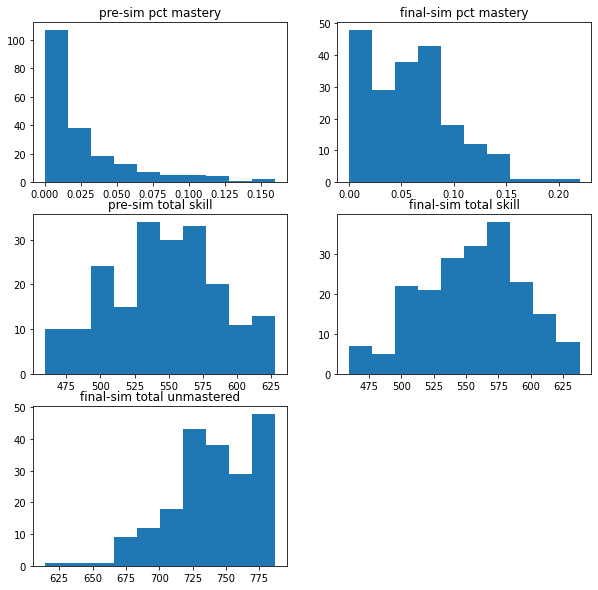

INFO:analytics.batch:Total skills: 787


In [33]:
# Plot mastery
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.hist(stu_stat['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(322)
plt.hist(stu_stat['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")


plt.subplot(323)
plt.hist(stu_stat['pre-sim total skill'], bins=10)
plt.title("pre-sim total skill")

plt.subplot(324)
plt.hist(stu_stat['final-sim total skill'], bins=10)
plt.title("final-sim total skill")



plt.subplot(325)
plt.hist(stu_stat['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()

# plt.figure(figsize=(4,4))
# plt.scatter(sim_students[])
logger.info("Total skills: %i" % sim_students['total skills'][0])

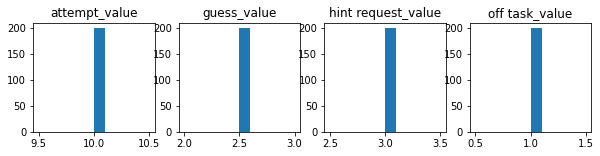

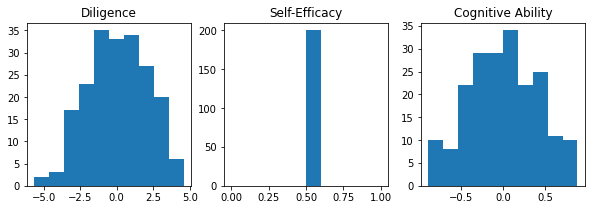

In [34]:
# Plot Values & Diligence
num_vals = len([col for col in sim_students.columns if "_value" in col])
plt.figure(figsize=(10,2))
i=1
for field in sim_students.columns:
    if "_value" in field:
        plt.subplot(1,num_vals, i)
        plt.hist(stu_stat[field], bins=10)
        plt.title(field)

        i +=1
# for i,val in enumerate(sim_students['values'][0].keys()):
#     print("%i: %s" % (i, val))
#     plt.subplot(2,2,i+1)
#     plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
#     plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.hist(stu_stat['diligence'], bins=10)
plt.title("Diligence")

plt.subplot(132)
plt.hist(stu_stat['dec_self_eff'], bins=10)
plt.title("Self-Efficacy")

plt.subplot(133)
plt.hist(stu_stat['cog_ability'], bins=10)
plt.title("Cognitive Ability")


plt.show()



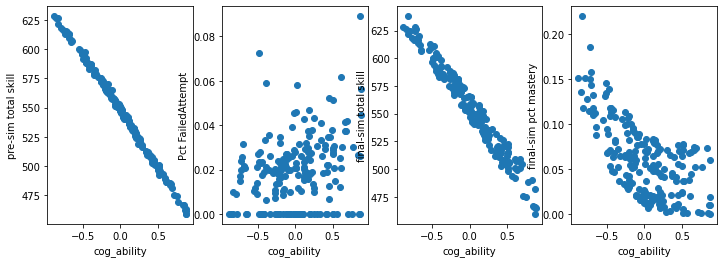

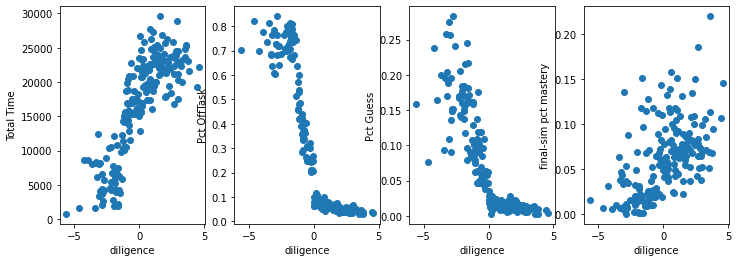

In [35]:
plt.figure(figsize=(12,4))
plt.subplot(141)
xcol = 'cog_ability'
ycol = 'pre-sim total skill'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(142)
xcol = 'cog_ability'
ycol = 'Pct FailedAttempt'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(143)
xcol = 'cog_ability'
ycol = 'final-sim total skill'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(144)
xcol = 'cog_ability'
ycol = 'final-sim pct mastery'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.show()


plt.figure(figsize=(12,4))
plt.subplot(141)
xcol = "diligence"
ycol = "Total Time"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(142)
xcol = "diligence"
ycol = "Pct OffTask"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(143)
xcol = "diligence"
ycol = "Pct Guess"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(144)
xcol = "diligence"
ycol = "final-sim pct mastery"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.show()

#### Learner Actions EDA

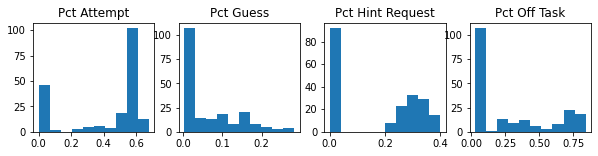

In [36]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(stu_stat['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(stu_stat['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(stu_stat['Pct HintRequest'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(stu_stat['Pct OffTask'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Transactions EDA

In [37]:
tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, 'type': "TutorInput"}))
tx.index = tx['_id']
logger.info(f"tx shape before expanding kcs {tx.shape}")
tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
#tx.rename(columns={'kcs': 'kc'}, inplace=True)
logger.info(f"tx shape after expanding kcs {tx.shape}")


INFO:analytics.batch:tx shape before expanding kcs (55387, 18)
INFO:analytics.batch:tx shape after expanding kcs (55387, 19)


In [38]:
def is_guess(tx, thres=2, kc_stats=None):
    if kc_stats is None:
        d = tx.apply(lambda x: x['duration'] <= thres, axis=1)
        return d
    else:
        if 'kc' not in tx.columns:
            tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
        d = tx.apply(lambda x: (x['outcome'] == 'Incorrect') & (x['duration'] <= (kc_stats[x['kc']])), axis=1)
        return d

##### Detector Performance

In [39]:
# Add ground truth and Detector labels
kc_long_tx = detector.get_kc_long_cutoff(tx)
kc_short_tx = detector.get_kc_short_cutoff(tx)

# Add Ground truth labels
tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
tx['is_guess'] = gt_lblr.label_guess_tx(tx)

# Add detector labels
tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)

In [40]:
# Plot Detector vs ground truth
tx['offtask_tp'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == True)
tx['offtask_fp'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == True)
tx['offtask_tn'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == False)
tx['offtask_fn'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == False)

tp = np.sum(tx['offtask_tp']) / tx.shape[0]
fp = np.sum(tx['offtask_fp']) / tx.shape[0]
tn = np.sum(tx['offtask_tn']) / tx.shape[0]
fn = np.sum(tx['offtask_fn']) / tx.shape[0]

logger.info(f"Offtask Error Rates: \nTP: {tp}\tFP: {fp}\tTN: {tn}\tFN: {fn}")

tx['guess_tp'] = (tx['is_guess'] == True) & (tx['detect_guess'] == True)
tx['guess_fp'] = (tx['is_guess'] == False) & (tx['detect_guess'] == True)
tx['guess_tn'] = (tx['is_guess'] == False) & (tx['detect_guess'] == False)
tx['guess_fn'] = (tx['is_guess'] == True) & (tx['detect_guess'] == False)

tp = np.sum(tx['guess_tp']) / tx.shape[0]
fp = np.sum(tx['guess_fp']) / tx.shape[0]
tn = np.sum(tx['guess_tn']) / tx.shape[0]
fn = np.sum(tx['guess_fn']) / tx.shape[0]

logger.info(f"Guess Error Rates: \nTP: {tp}\tFP: {fp}\tTN: {tn}\tFN: {fn}")

INFO:analytics.batch:Offtask Error Rates: 
TP: 0.05880441258779136	FP: 0.041814866304367454	TN: 0.8992182281040677	FN: 0.00016249300377344864
INFO:analytics.batch:Guess Error Rates: 
TP: 0.0036109556394099697	FP: 0.001317998808384639	TN: 0.9700651777492914	FN: 0.025005867802914042


In [41]:
stu_prob_stats = calc.get_stu_prob_stats(tx)
kc_stats = calc.get_kc_stats(tx)

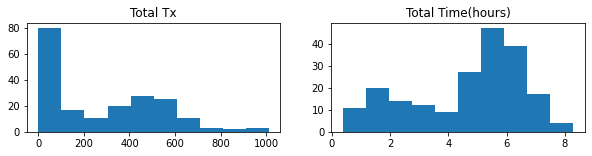

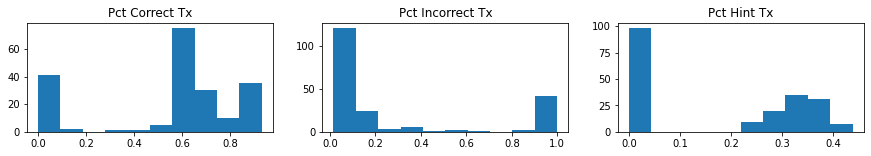

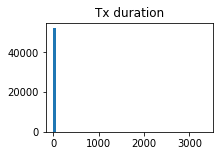

In [42]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(tx_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(tx_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(tx_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(tx_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(tx_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

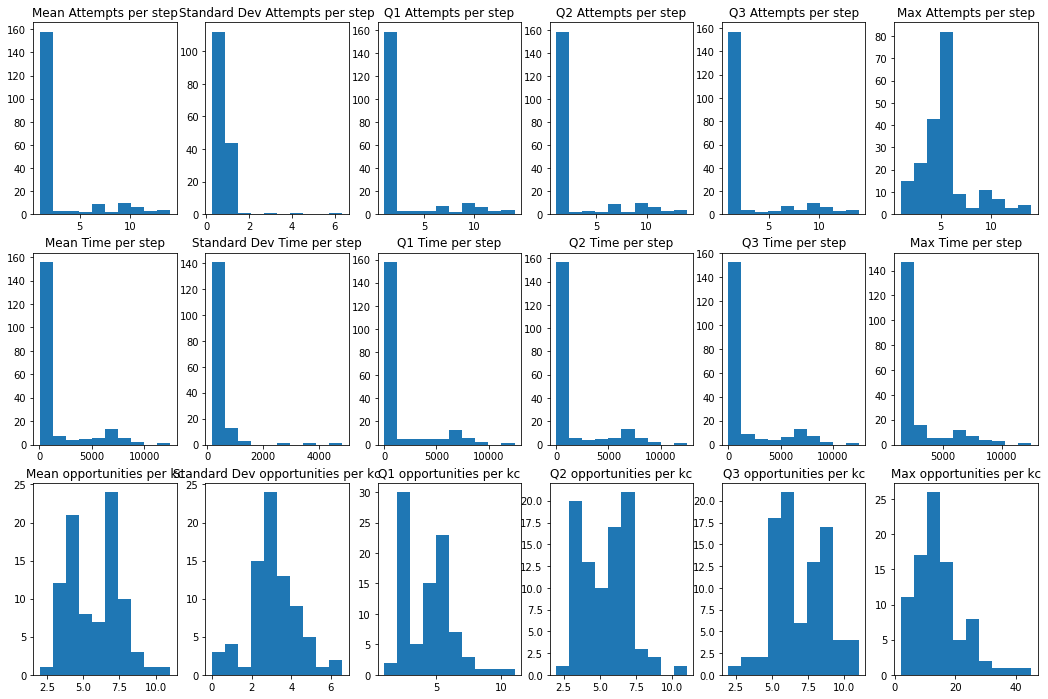

In [43]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


##### Time on Task

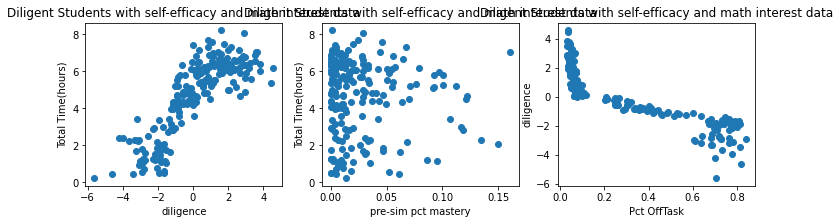

In [44]:

plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
xcol = "diligence"
ycol = "Total Time(hours)"
plt.title(f"{desc} data")
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(1,3,2)
xcol = "pre-sim pct mastery"
ycol = "Total Time(hours)"
plt.title(f"{desc} data")
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(1,3,3)
xcol = "Pct OffTask"
ycol = "diligence"
plt.title(f"{desc} data")
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.show()

### Diligent Students with Self-Efficacy

#### Student Parameters

In [45]:
idx = 1
sim_batch_desc = batch_descs[idx]
stu_stat = stu_stats[sim_batch_desc]
logger.info(f"EDA of {len(sid)} students")

INFO:analytics.batch:EDA of 200 students


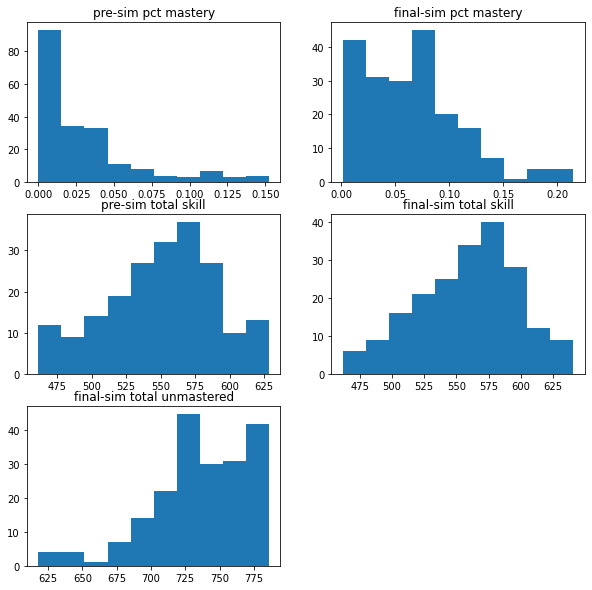

INFO:analytics.batch:Total skills: 787


In [46]:
# Plot mastery
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.hist(stu_stat['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(322)
plt.hist(stu_stat['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")


plt.subplot(323)
plt.hist(stu_stat['pre-sim total skill'], bins=10)
plt.title("pre-sim total skill")

plt.subplot(324)
plt.hist(stu_stat['final-sim total skill'], bins=10)
plt.title("final-sim total skill")



plt.subplot(325)
plt.hist(stu_stat['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()

# plt.figure(figsize=(4,4))
# plt.scatter(sim_students[])
logger.info("Total skills: %i" % sim_students['total skills'][0])

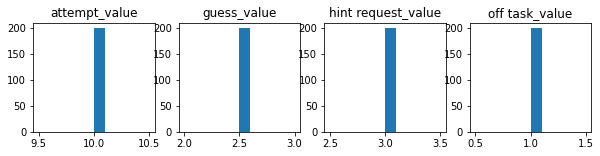

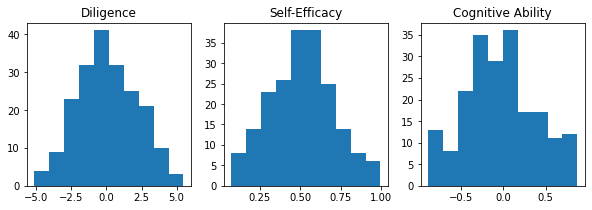

In [47]:
# Plot Values & Diligence
num_vals = len([col for col in sim_students.columns if "_value" in col])
plt.figure(figsize=(10,2))
i=1
for field in sim_students.columns:
    if "_value" in field:
        plt.subplot(1,num_vals, i)
        plt.hist(stu_stat[field], bins=10)
        plt.title(field)

        i +=1
# for i,val in enumerate(sim_students['values'][0].keys()):
#     print("%i: %s" % (i, val))
#     plt.subplot(2,2,i+1)
#     plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
#     plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.hist(stu_stat['diligence'], bins=10)
plt.title("Diligence")

plt.subplot(132)
plt.hist(stu_stat['dec_self_eff'], bins=10)
plt.title("Self-Efficacy")

plt.subplot(133)
plt.hist(stu_stat['cog_ability'], bins=10)
plt.title("Cognitive Ability")


plt.show()



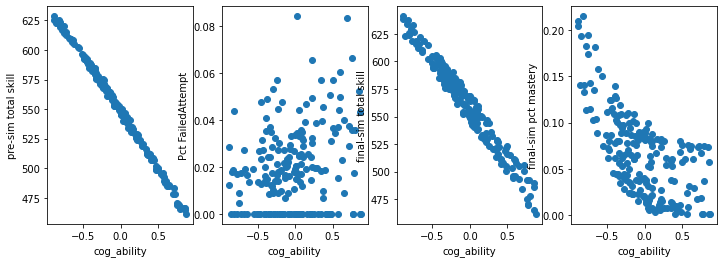

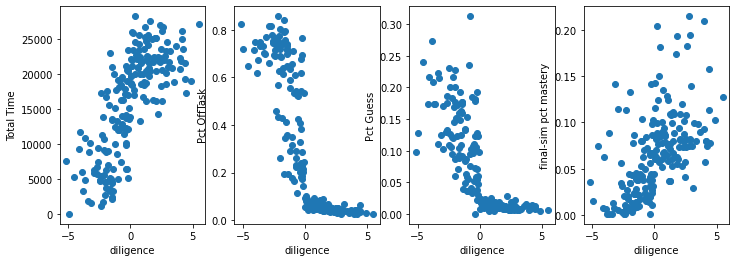

In [48]:
plt.figure(figsize=(12,4))
plt.subplot(141)
xcol = 'cog_ability'
ycol = 'pre-sim total skill'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(142)
xcol = 'cog_ability'
ycol = 'Pct FailedAttempt'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(143)
xcol = 'cog_ability'
ycol = 'final-sim total skill'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(144)
xcol = 'cog_ability'
ycol = 'final-sim pct mastery'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.show()


plt.figure(figsize=(12,4))
plt.subplot(141)
xcol = "diligence"
ycol = "Total Time"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(142)
xcol = "diligence"
ycol = "Pct OffTask"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(143)
xcol = "diligence"
ycol = "Pct Guess"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(144)
xcol = "diligence"
ycol = "final-sim pct mastery"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.show()

#### Learner Actions EDA

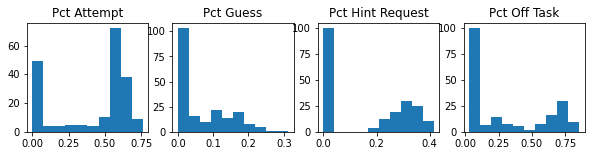

In [49]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(stu_stat['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(stu_stat['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(stu_stat['Pct HintRequest'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(stu_stat['Pct OffTask'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Transactions EDA

In [50]:
tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, 'type': "TutorInput"}))
tx.index = tx['_id']
logger.info(f"tx shape before expanding kcs {tx.shape}")
tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
#tx.rename(columns={'kcs': 'kc'}, inplace=True)
logger.info(f"tx shape after expanding kcs {tx.shape}")


INFO:analytics.batch:tx shape before expanding kcs (55387, 18)
INFO:analytics.batch:tx shape after expanding kcs (55387, 19)


##### Detector Performance

In [51]:
# Add ground truth and Detector labels
kc_long_tx = detector.get_kc_long_cutoff(tx)
kc_short_tx = detector.get_kc_short_cutoff(tx)

# Add Ground truth labels
tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
tx['is_guess'] = gt_lblr.label_guess_tx(tx)

# Add detector labels
tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)

In [52]:
# Plot Detector vs ground truth
tx['offtask_tp'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == True)
tx['offtask_fp'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == True)
tx['offtask_tn'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == False)
tx['offtask_fn'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == False)

tp = np.sum(tx['offtask_tp']) / tx.shape[0]
fp = np.sum(tx['offtask_fp']) / tx.shape[0]
tn = np.sum(tx['offtask_tn']) / tx.shape[0]
fn = np.sum(tx['offtask_fn']) / tx.shape[0]

logger.info(f"Offtask Error Rates: \nTP: {tp}\tFP: {fp}\tTN: {tn}\tFN: {fn}")

tx['guess_tp'] = (tx['is_guess'] == True) & (tx['detect_guess'] == True)
tx['guess_fp'] = (tx['is_guess'] == False) & (tx['detect_guess'] == True)
tx['guess_tn'] = (tx['is_guess'] == False) & (tx['detect_guess'] == False)
tx['guess_fn'] = (tx['is_guess'] == True) & (tx['detect_guess'] == False)

tp = np.sum(tx['guess_tp']) / tx.shape[0]
fp = np.sum(tx['guess_fp']) / tx.shape[0]
tn = np.sum(tx['guess_tn']) / tx.shape[0]
fn = np.sum(tx['guess_fn']) / tx.shape[0]

logger.info(f"Guess Error Rates: \nTP: {tp}\tFP: {fp}\tTN: {tn}\tFN: {fn}")

INFO:analytics.batch:Offtask Error Rates: 
TP: 0.05880441258779136	FP: 0.041814866304367454	TN: 0.8992182281040677	FN: 0.00016249300377344864
INFO:analytics.batch:Guess Error Rates: 
TP: 0.0036109556394099697	FP: 0.001317998808384639	TN: 0.9700651777492914	FN: 0.025005867802914042


In [53]:
stu_prob_stats = calc.get_stu_prob_stats(tx)
kc_stats = calc.get_kc_stats(tx)

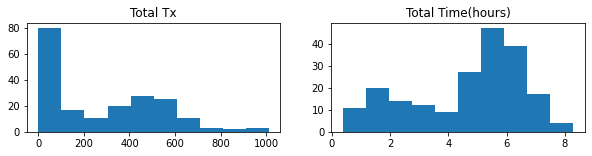

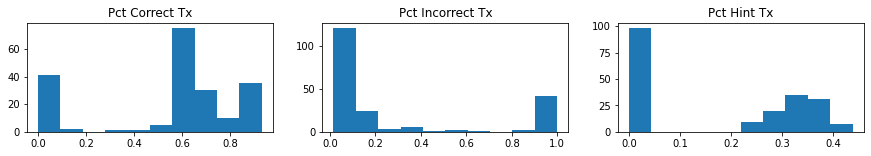

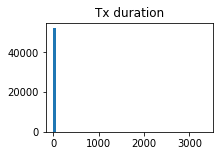

In [54]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(tx_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(tx_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(tx_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(tx_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(tx_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

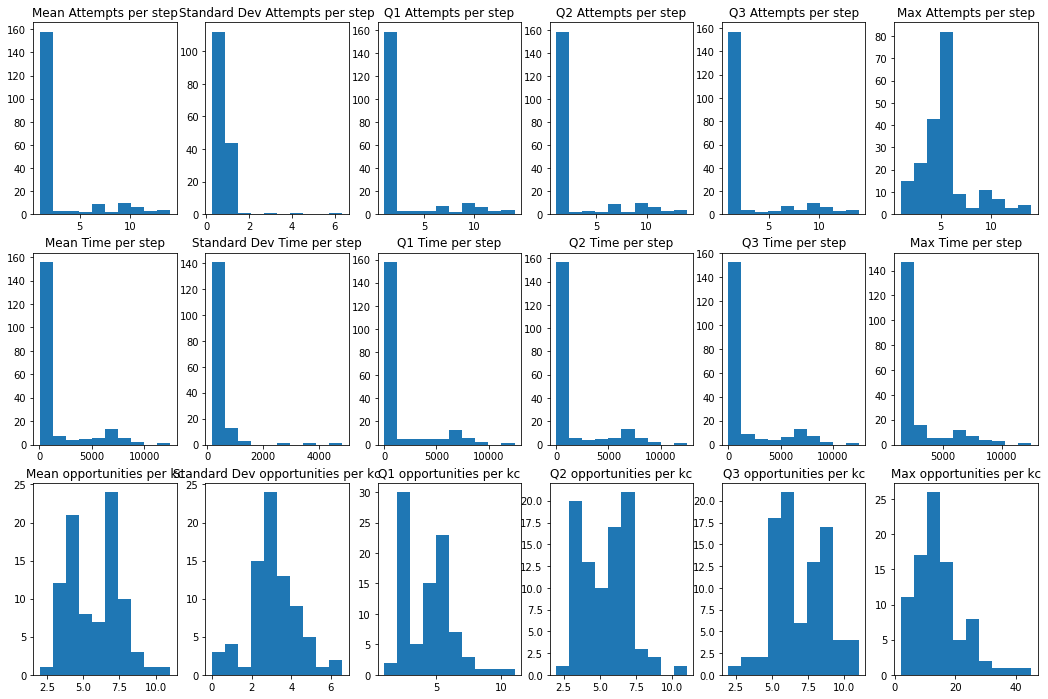

In [55]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


##### Time on Task

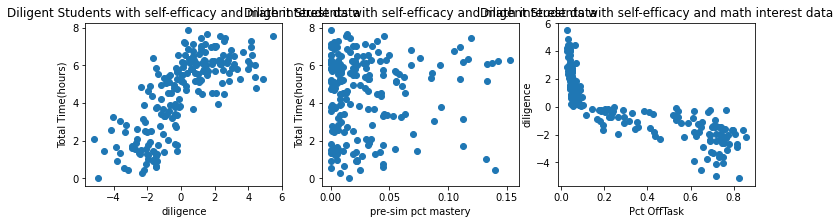

In [56]:

plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
xcol = "diligence"
ycol = "Total Time(hours)"
plt.title(f"{desc} data")
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(1,3,2)
xcol = "pre-sim pct mastery"
ycol = "Total Time(hours)"
plt.title(f"{desc} data")
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(1,3,3)
xcol = "Pct OffTask"
ycol = "diligence"
plt.title(f"{desc} data")
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.show()

### Diligent with self-efficacy & Math Interest

#### Student Parameters

In [57]:
idx = 1
sim_batch_desc = batch_descs[idx]
stu_stat = stu_stats[sim_batch_desc]
logger.info(f"EDA of {len(sid)} students")

INFO:analytics.batch:EDA of 200 students


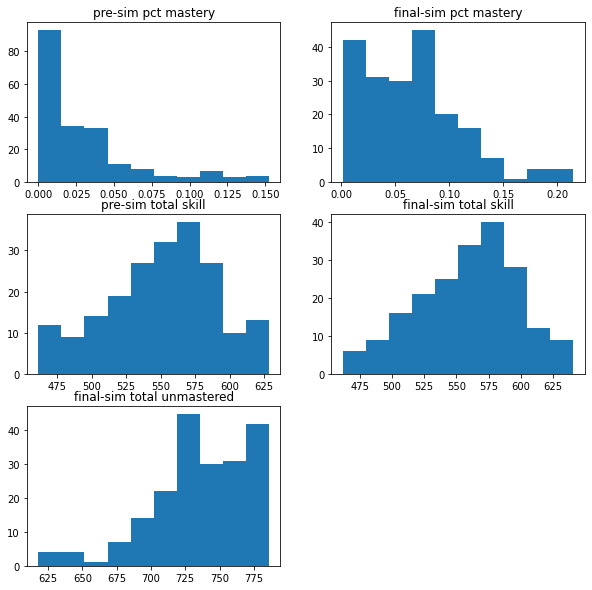

INFO:analytics.batch:Total skills: 787


In [58]:
# Plot mastery
plt.figure(figsize=(10,10))
plt.subplot(321)
plt.hist(stu_stat['pre-sim pct mastery'], bins=10)
plt.title("pre-sim pct mastery")

plt.subplot(322)
plt.hist(stu_stat['final-sim pct mastery'], bins=10)
plt.title("final-sim pct mastery")


plt.subplot(323)
plt.hist(stu_stat['pre-sim total skill'], bins=10)
plt.title("pre-sim total skill")

plt.subplot(324)
plt.hist(stu_stat['final-sim total skill'], bins=10)
plt.title("final-sim total skill")



plt.subplot(325)
plt.hist(stu_stat['final-sim total unmastered'], bins=10)
plt.title("final-sim total unmastered")

plt.show()

# plt.figure(figsize=(4,4))
# plt.scatter(sim_students[])
logger.info("Total skills: %i" % sim_students['total skills'][0])

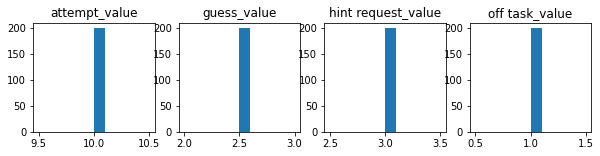

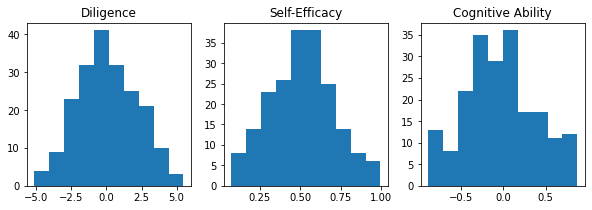

In [59]:
# Plot Values & Diligence
num_vals = len([col for col in sim_students.columns if "_value" in col])
plt.figure(figsize=(10,2))
i=1
for field in sim_students.columns:
    if "_value" in field:
        plt.subplot(1,num_vals, i)
        plt.hist(stu_stat[field], bins=10)
        plt.title(field)

        i +=1
# for i,val in enumerate(sim_students['values'][0].keys()):
#     print("%i: %s" % (i, val))
#     plt.subplot(2,2,i+1)
#     plt.hist(sim_students['values'].apply(lambda x: x[val]), bins=10)
#     plt.title('Student value for %s' % val)

plt.show()

plt.figure(figsize=(10,3))
plt.subplot(131)
plt.hist(stu_stat['diligence'], bins=10)
plt.title("Diligence")

plt.subplot(132)
plt.hist(stu_stat['dec_self_eff'], bins=10)
plt.title("Self-Efficacy")

plt.subplot(133)
plt.hist(stu_stat['cog_ability'], bins=10)
plt.title("Cognitive Ability")


plt.show()



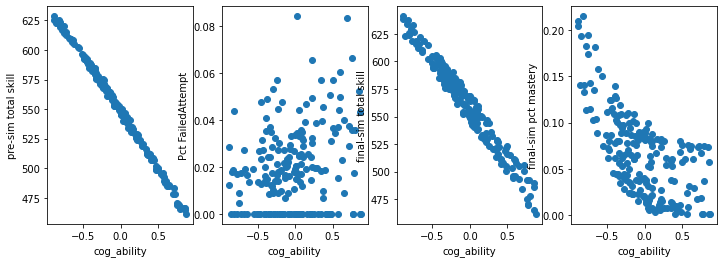

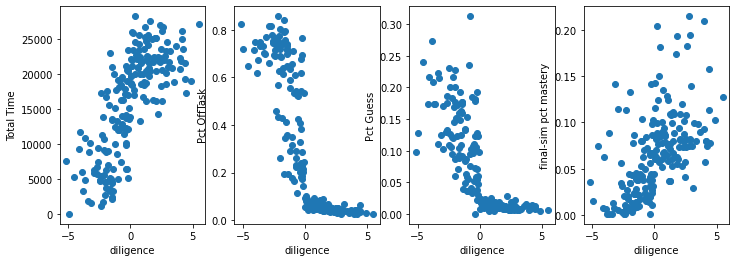

In [60]:
plt.figure(figsize=(12,4))
plt.subplot(141)
xcol = 'cog_ability'
ycol = 'pre-sim total skill'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(142)
xcol = 'cog_ability'
ycol = 'Pct FailedAttempt'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(143)
xcol = 'cog_ability'
ycol = 'final-sim total skill'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(144)
xcol = 'cog_ability'
ycol = 'final-sim pct mastery'
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.show()


plt.figure(figsize=(12,4))
plt.subplot(141)
xcol = "diligence"
ycol = "Total Time"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(142)
xcol = "diligence"
ycol = "Pct OffTask"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(143)
xcol = "diligence"
ycol = "Pct Guess"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(144)
xcol = "diligence"
ycol = "final-sim pct mastery"
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.show()

#### Learner Actions EDA

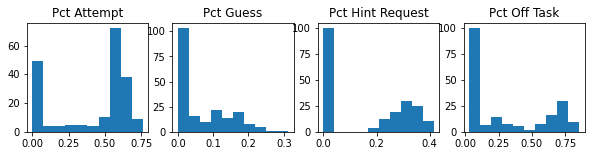

In [61]:
plt.figure(figsize=(10,2))
plt.subplot(141)
plt.hist(stu_stat['Pct Attempt'], bins=10)
plt.title("Pct Attempt")

plt.subplot(142)
plt.hist(stu_stat['Pct Guess'], bins=10)
plt.title("Pct Guess")

plt.subplot(143)
plt.hist(stu_stat['Pct HintRequest'], bins=10)
plt.title("Pct Hint Request")

plt.subplot(144)
plt.hist(stu_stat['Pct OffTask'], bins=10)
plt.title("Pct Off Task")

plt.show()

#### Learner Transactions EDA

In [62]:
tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, 'type': "TutorInput"}))
tx.index = tx['_id']
logger.info(f"tx shape before expanding kcs {tx.shape}")
tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
#tx.rename(columns={'kcs': 'kc'}, inplace=True)
logger.info(f"tx shape after expanding kcs {tx.shape}")


INFO:analytics.batch:tx shape before expanding kcs (55387, 18)
INFO:analytics.batch:tx shape after expanding kcs (55387, 19)


##### Detector Performance

In [63]:
# Add ground truth and Detector labels
kc_long_tx = detector.get_kc_long_cutoff(tx)
kc_short_tx = detector.get_kc_short_cutoff(tx)

# Add Ground truth labels
tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
tx['is_guess'] = gt_lblr.label_guess_tx(tx)

# Add detector labels
tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)



In [64]:
# Plot Detector vs ground truth
tx['offtask_tp'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == True)
tx['offtask_fp'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == True)
tx['offtask_tn'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == False)
tx['offtask_fn'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == False)

tp = np.sum(tx['offtask_tp']) / tx.shape[0]
fp = np.sum(tx['offtask_fp']) / tx.shape[0]
tn = np.sum(tx['offtask_tn']) / tx.shape[0]
fn = np.sum(tx['offtask_fn']) / tx.shape[0]

logger.info(f"Offtask Error Rates: \nTP: {tp}\tFP: {fp}\tTN: {tn}\tFN: {fn}")

tx['guess_tp'] = (tx['is_guess'] == True) & (tx['detect_guess'] == True)
tx['guess_fp'] = (tx['is_guess'] == False) & (tx['detect_guess'] == True)
tx['guess_tn'] = (tx['is_guess'] == False) & (tx['detect_guess'] == False)
tx['guess_fn'] = (tx['is_guess'] == True) & (tx['detect_guess'] == False)

tp = np.sum(tx['guess_tp']) / tx.shape[0]
fp = np.sum(tx['guess_fp']) / tx.shape[0]
tn = np.sum(tx['guess_tn']) / tx.shape[0]
fn = np.sum(tx['guess_fn']) / tx.shape[0]

logger.info(f"Guess Error Rates: \nTP: {tp}\tFP: {fp}\tTN: {tn}\tFN: {fn}")

INFO:analytics.batch:Offtask Error Rates: 
TP: 0.05880441258779136	FP: 0.041814866304367454	TN: 0.8992182281040677	FN: 0.00016249300377344864
INFO:analytics.batch:Guess Error Rates: 
TP: 0.0036109556394099697	FP: 0.001317998808384639	TN: 0.9700651777492914	FN: 0.025005867802914042


In [65]:
stu_prob_stats = calc.get_stu_prob_stats(tx)
kc_stats = calc.get_kc_stats(tx)

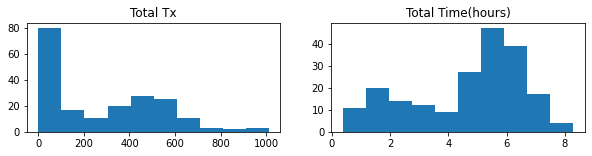

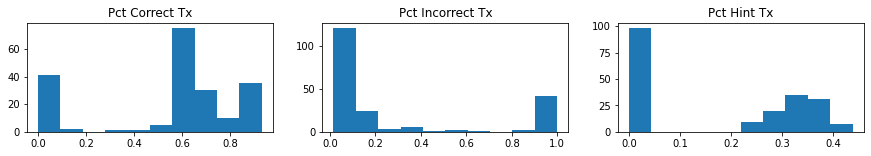

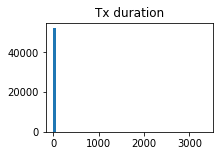

In [66]:
plt.figure(figsize=(10,2))
plt.subplot(121)
plt.hist(tx_stats['Total Tx'], bins=10)
plt.title("Total Tx")

plt.subplot(122)
plt.hist(tx_stats['Total Time(hours)'], bins=10)
plt.title("Total Time(hours)")
plt.show()

plt.figure(figsize=(15,2))
plt.subplot(131)
plt.hist(tx_stats['Pct Correct'], bins=10)
plt.title("Pct Correct Tx")

plt.subplot(132)
plt.hist(tx_stats['Pct Incorrect'], bins=10)
plt.title("Pct Incorrect Tx")

plt.subplot(133)
plt.hist(tx_stats['Pct Hint'], bins=10)
plt.title("Pct Hint Tx")
plt.show()

plt.figure(figsize=(3,2))
plt.hist(tx['duration'],bins=50)
plt.title("Tx duration")
plt.show()

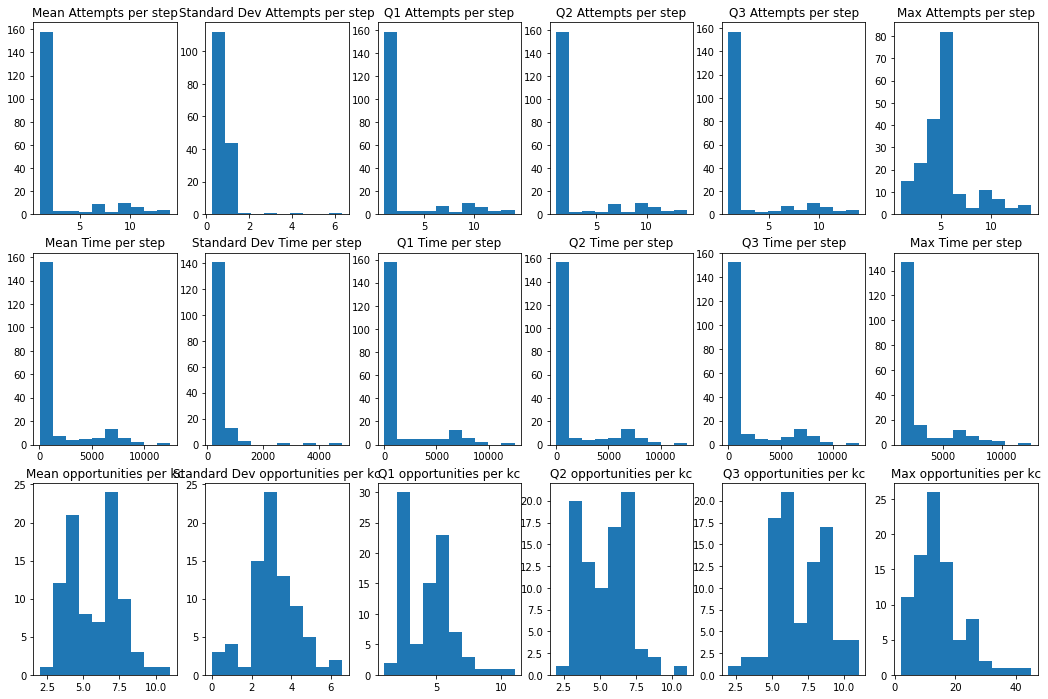

In [67]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
plt.title("Max opportunities per kc")

plt.show()


##### Time on Task

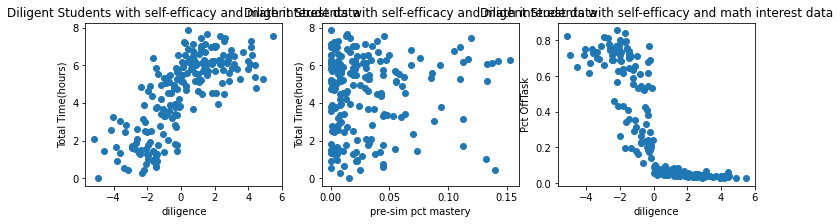

In [68]:

plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
xcol = "diligence"
ycol = "Total Time(hours)"
plt.title(f"{desc} data")
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(1,3,2)
xcol = "pre-sim pct mastery"
ycol = "Total Time(hours)"
plt.title(f"{desc} data")
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.subplot(1,3,3)
ycol = "Pct OffTask"
xcol = "diligence"
plt.title(f"{desc} data")
plt.scatter(stu_stat[xcol], stu_stat[ycol])
plt.xlabel(xcol)
plt.ylabel(ycol)

plt.show()

## 3. Estimating Diligence

Estimators to compare
1. M1: Frequency of Off-task measure
2. M2 Total Time-on-task as a proportion of opportunity
3. M3: Time-on-task as a proportion of opportunity, subtracting off-task time
4. M4: Multiple Diligence Measures
5. M5: Multiple Diligence & Multiple Cognitive Measure instrument
6: M6: Multiple diligence & Cog measures + CAE measures.

Seed Model

* Measures of Cognition
    * Accuracy
    * P(error | opp = 1) over all kc's
    * E[P(mastery = k | kc)]
    * Total Skills mastered

* Measures of Diligence
    * Time in system  
    * Frequency of Off-task
    * P(guess) 



### Helpers

In [69]:
def get_tx(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, 'type': "TutorInput"}))
    tx.index = tx['_id']
    tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
    return tx

def lbl_nondil_tx(tx):
    detector = Detector(db) 
    gt_lblr = TransactionAnnotator(db)
    
    kc_long_tx = detector.get_kc_long_cutoff(tx)
    kc_short_tx = detector.get_kc_short_cutoff(tx)

    # Add Ground truth labels (using global db var)

    tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
    tx['is_guess'] = gt_lblr.label_guess_tx(tx)

    # Add detector labels
    tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
    tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)
    return tx
    


In [70]:
def calc_accuracy(tx_stats):
    d =  tx_stats['Correct']/ tx_stats['Total Tx']
    d.rename("accuracy", inplace=True)
    return d

def calc_err_on_1_opp(tx):
    d = tx[tx['attempt'] == 0]
    # Get 1st opportunity
    cols = [col for col in d.columns if col not in ['stu_id', 'kc']]
    opp1 = d.groupby(['stu_id', 'kc']).apply(lambda x: x.iloc[0][cols]).reset_index()
    opp1['is_correct'] = opp1['outcome'] == "Correct"
    ## Calculate P(Correct) per student
    opp1 =  opp1.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x))
    opp1.rename("err_on_1_opp", inplace=True)
    return opp1

def calc_avg_prac_opp(tx, mastery_thres=0.9):
    # Get the learner knowledge at the end of each practice step
    d = tx.groupby(['stu_id', 'kc', 'step_id'])['plt1'].apply(lambda x: x[-1]).reset_index()
    d['has_mastered'] = d['plt1'] >= mastery_thres
    # Getting student-kc pairings for analysis
    stu_kc = d.loc[d['has_mastered'], ['stu_id','kc']].drop_duplicates()
    # Get just tx for relevant stu-kc's
    d = pd.merge(tx, stu_kc, on=['stu_id', 'kc'], how='inner')
    d = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
    d = d.groupby('stu_id')['step_id'].mean()
    d.rename('avg_prac_opp', inplace=True)
    return d

def calc_p_guess(tx):
    d = tx.groupby('stu_id')['detect_guess'].apply(lambda x: np.sum(x) / len(x))
    d.rename("p_guess", inplace=True)
    return d

def calc_detected_offtask(tx):
    if "detect_offtask" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_offtask'].mean()

    d.rename("mean_detect_offtask", inplace=True)
    return d

def calc_detected_guess(tx):
    if "detect_guess" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_guess'].mean()

    d.rename("mean_detect_guess", inplace=True)
    return d

def calc_time_on_task(tx):
    d = tx.pivot_table(index="stu_id", columns="is_offtask", values="duration", fill_value=0).reset_index()
    d.index = d['stu_id']
    d.rename(columns={False: "time_on_task", True: "time_off_task"}, inplace=True)
    d.drop(columns=['stu_id'], inplace=True)
    return d

    
    


In [71]:
# Add ground truth and Detector labels
kc_long_tx = detector.get_kc_long_cutoff(tx)
kc_short_tx = detector.get_kc_short_cutoff(tx)

# Add Ground truth labels
tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
tx['is_guess'] = gt_lblr.label_guess_tx(tx)

# Add detector labels
tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)

In [72]:
# Plot Detector vs ground truth
tx['offtask_tp'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == True)
tx['offtask_fp'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == True)
tx['offtask_tn'] = (tx['is_offtask'] == False) & (tx['detect_offtask'] == False)
tx['offtask_fn'] = (tx['is_offtask'] == True) & (tx['detect_offtask'] == False)

tp = np.sum(tx['offtask_tp']) / tx.shape[0]
fp = np.sum(tx['offtask_fp']) / tx.shape[0]
tn = np.sum(tx['offtask_tn']) / tx.shape[0]
fn = np.sum(tx['offtask_fn']) / tx.shape[0]

logger.info(f"Offtask Error Rates: \nTP: {tp}\tFP: {fp}\tTN: {tn}\tFN: {fn}")

tx['guess_tp'] = (tx['is_guess'] == True) & (tx['detect_guess'] == True)
tx['guess_fp'] = (tx['is_guess'] == False) & (tx['detect_guess'] == True)
tx['guess_tn'] = (tx['is_guess'] == False) & (tx['detect_guess'] == False)
tx['guess_fn'] = (tx['is_guess'] == True) & (tx['detect_guess'] == False)

tp = np.sum(tx['guess_tp']) / tx.shape[0]
fp = np.sum(tx['guess_fp']) / tx.shape[0]
tn = np.sum(tx['guess_tn']) / tx.shape[0]
fn = np.sum(tx['guess_fn']) / tx.shape[0]

logger.info(f"Guess Error Rates: \nTP: {tp}\tFP: {fp}\tTN: {tn}\tFN: {fn}")

INFO:analytics.batch:Offtask Error Rates: 
TP: 0.05880441258779136	FP: 0.041814866304367454	TN: 0.8992182281040677	FN: 0.00016249300377344864
INFO:analytics.batch:Guess Error Rates: 
TP: 0.0036109556394099697	FP: 0.001317998808384639	TN: 0.9700651777492914	FN: 0.025005867802914042


### Calc Measures

In [73]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_descs = ["Simple diligent students",
              "Diligent Students with domain-level self-efficacy",
              "Diligent Students with self-efficacy and math interest"]
sids = {desc: [] for desc in batch_descs}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_descs:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.batch:batch #0: 
ID: 8e29893c-473f-4cd7-bb08-d619d085c9db
desc: Simple diligent students
INFO:analytics.batch:recovered 200 student ids for batch Simple diligent students
INFO:analytics.batch:batch #1: 
ID: 7e786c01-b460-4e7d-b15b-6012f4bd37f3
desc: Diligent Students with domain-level self-efficacy
INFO:analytics.batch:recovered 200 student ids for batch Diligent Students with domain-level self-efficacy
INFO:analytics.batch:batch #2: 
ID: 69573900-86e5-4d21-beaf-24434a880380
desc: Diligent Students with self-efficacy and math interest
INFO:analytics.batch:recovered 200 student ids for batch Diligent Students with self-efficacy and math interest


In [74]:
stu_stats = {desc: {} for desc in batch_descs}
mastery_thres = 0.9

for desc in batch_descs:
    sid = sids[desc][0]
    logger.info(f"Calculating for student set {desc}")
    args = [get_stu_parameters, sid, 10, [mastery_thres]]
    sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

    args = [calc.get_action_counts, sid, 10]
    action_dist, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

    args = [calc.total_tx_stats, sid, 10]
    tx_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")

    tx = get_tx(sid)
    tx = lbl_nondil_tx(tx)

    accuracy = calc_accuracy(tx_stats)
    err_on_1_opp = calc_err_on_1_opp(tx)
    avg_prac_opp = calc_avg_prac_opp(tx)
    p_guess = calc_p_guess(tx)
    detect_offtask = calc_detected_offtask(tx)
    detect_guess = calc_detected_guess(tx)
    time_on_task = calc_time_on_task(tx)

    stu_stats[desc] = pd.concat([sim_students, action_dist, tx_stats, accuracy, \
                                 err_on_1_opp, avg_prac_opp, p_guess, detect_guess, detect_offtask, time_on_task], axis=1)
    logger.info(f"Merged new stats together: {stu_stats[desc].shape}")


INFO:analytics.batch:Calculating for student set Simple diligent students
INFO:analytics.batch:Calculated student params: (200, 18)	Runtime: 1.083594 seconds
INFO:analytics.batch:Calculated student action stats: (200, 13)	Runtime: 4.726299 seconds
INFO:analytics.batch:Calculated student activity stats: (200, 9)	Runtime: 6.006564 seconds
INFO:analytics.batch:Merged new stats together: (200, 48)
INFO:analytics.batch:Calculating for student set Diligent Students with domain-level self-efficacy
INFO:analytics.batch:Calculated student params: (200, 18)	Runtime: 1.036379 seconds
INFO:analytics.batch:Calculated student action stats: (200, 13)	Runtime: 4.724969 seconds
INFO:analytics.batch:Calculated student activity stats: (200, 9)	Runtime: 6.104833 seconds
INFO:analytics.batch:Merged new stats together: (200, 48)
INFO:analytics.batch:Calculating for student set Diligent Students with self-efficacy and math interest
INFO:analytics.batch:Calculated student params: (200, 19)	Runtime: 1.099297 s

In [75]:
stu_stat = stu_stats[batch_descs[0]]
stu_stat.head()

,attempt_value,guess_value,hint request_value,off task_value,diligence,cog_ability,dec_self_eff,final skills,final total attempts,final total success,...,Pct Hint,Pct Incorrect,accuracy,err_on_1_opp,avg_prac_opp,p_guess,mean_detect_guess,mean_detect_offtask,time_on_task,time_off_task
09797aff-6a07-4426-b09f-d5120e22ad05,10,2.5,3,1,2.650088,-0.725712,0.5,"{'d278aa80-8084-4987-accf-0d524b86461c': 1, '8...",281,264,...,0.324519,0.040865,0.634615,0.500000,4.568966,0.000000,0.000000,0.088942,8.096228,850.169137
322ea64d-cc46-4965-a9c0-4b5275905699,10,2.5,3,1,-1.872363,-0.062898,0.5,{'d278aa80-8084-4987-accf-0d524b86461c': 0.581...,9,0,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.333333,0.333333,0.555556,0.551263,1059.117298
5489d2b7-4496-44fe-8cd7-23d5dbd55571,10,2.5,3,1,-0.321704,-0.195767,0.5,"{'d278aa80-8084-4987-accf-0d524b86461c': 1, '8...",71,59,...,0.000000,0.169014,0.830986,0.600000,3.933333,0.014085,0.014085,0.253521,6.788309,1005.419042
5832b4ca-eee1-4e7d-a152-743cb325bced,10,2.5,3,1,1.463875,-0.531578,0.5,"{'d278aa80-8084-4987-accf-0d524b86461c': 1, '8...",403,390,...,0.356230,0.020767,0.623003,0.542373,6.627119,0.001597,0.001597,0.075080,7.655802,806.731888
5e66561e-4540-4668-af6b-cef3a6ac4905,10,2.5,3,1,-3.430176,-0.417242,0.5,"{'d278aa80-8084-4987-accf-0d524b86461c': 1, '8...",4,1,...,0.000000,0.750000,0.250000,0.000000,1.000000,0.250000,0.250000,0.500000,0.000000,795.876706


In [76]:
for col in stu_stat:
    print(col)

attempt_value
guess_value
hint request_value
off task_value
diligence
cog_ability
dec_self_eff
final skills
final total attempts
final total success
pre-sim total mastery
pre-sim total skill
final-sim total mastery
final-sim total skill
total skills
pre-sim pct mastery
final-sim pct mastery
final-sim total unmastered
Attempt
FailedAttempt
Guess
HintRequest
OffTask
StopWork
total actions
Pct Attempt
Pct FailedAttempt
Pct Guess
Pct HintRequest
Pct OffTask
Pct StopWork
Total Tx
Total Time
Total Time(hours)
Correct
Hint
Incorrect
Pct Correct
Pct Hint
Pct Incorrect
accuracy
err_on_1_opp
avg_prac_opp
p_guess
mean_detect_guess
mean_detect_offtask
time_on_task
time_off_task


#### Simple Diligent

In [77]:
##### Mdl1: 

#### Diligent with Self-Efficacy

#### Diligent with Self-Eff and Math Interest

##### M1: Freq of Off-task

INFO:analytics.batch:Comparing student sim: Simple diligent students
INFO:analytics.batch:Correlation with Diligence: R = -0.8020905486653243	 pval = 3.309110689824561e-46
INFO:analytics.batch:Correlation with Cog Ability: R = -0.04331778435367579	 pval = 0.5424898945232512
INFO:analytics.batch:Comparing student sim: Diligent Students with domain-level self-efficacy
INFO:analytics.batch:Correlation with Diligence: R = -0.7307810104163377	 pval = 1.1319586568002415e-34
INFO:analytics.batch:Correlation with Cog Ability: R = -0.024964618171137237	 pval = 0.7256673005165771
INFO:analytics.batch:Comparing student sim: Diligent Students with self-efficacy and math interest
INFO:analytics.batch:Correlation with Diligence: R = -0.7468193422725435	 pval = 6.314097888048828e-37
INFO:analytics.batch:Correlation with Cog Ability: R = 0.09479694980324722	 pval = 0.1817987598788274


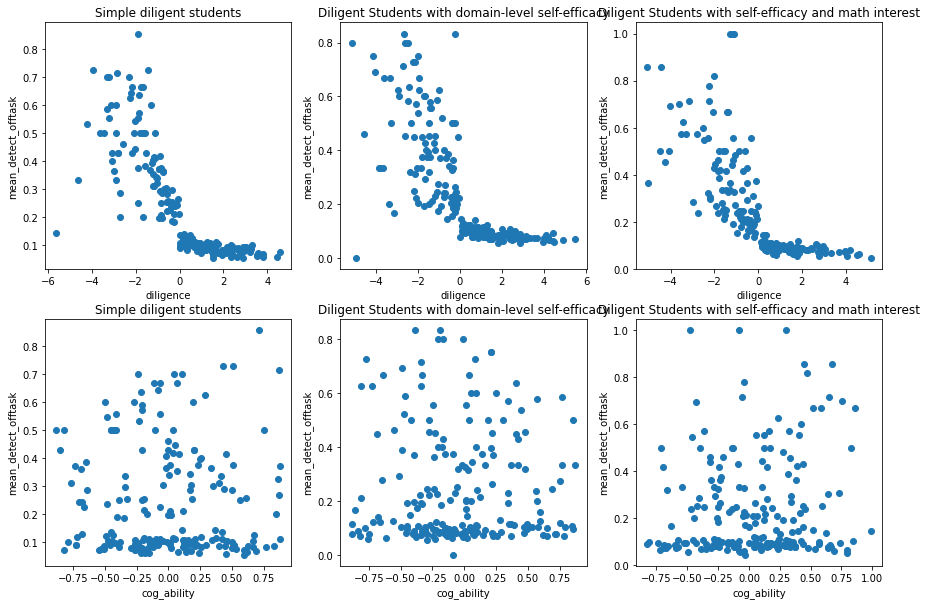

In [92]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "mean_detect_offtask"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

##### M2: Total Time

INFO:analytics.batch:Comparing student sim: Simple diligent students
INFO:analytics.batch:Correlation with Diligence: R = 0.8303047042076227	 pval = 3.630575025990564e-52
INFO:analytics.batch:Correlation with Cog Ability: R = 0.057234217944223	 pval = 0.4208192350547588
INFO:analytics.batch:Comparing student sim: Diligent Students with domain-level self-efficacy
INFO:analytics.batch:Correlation with Diligence: R = 0.7462514083088173	 pval = 7.638241731527747e-37
INFO:analytics.batch:Correlation with Cog Ability: R = -0.002908192654293188	 pval = 0.9673992564049649
INFO:analytics.batch:Comparing student sim: Diligent Students with self-efficacy and math interest
INFO:analytics.batch:Correlation with Diligence: R = 0.7053177544610435	 pval = 2.0762355914260574e-31
INFO:analytics.batch:Correlation with Cog Ability: R = -0.07024489950146959	 pval = 0.3229530263649985


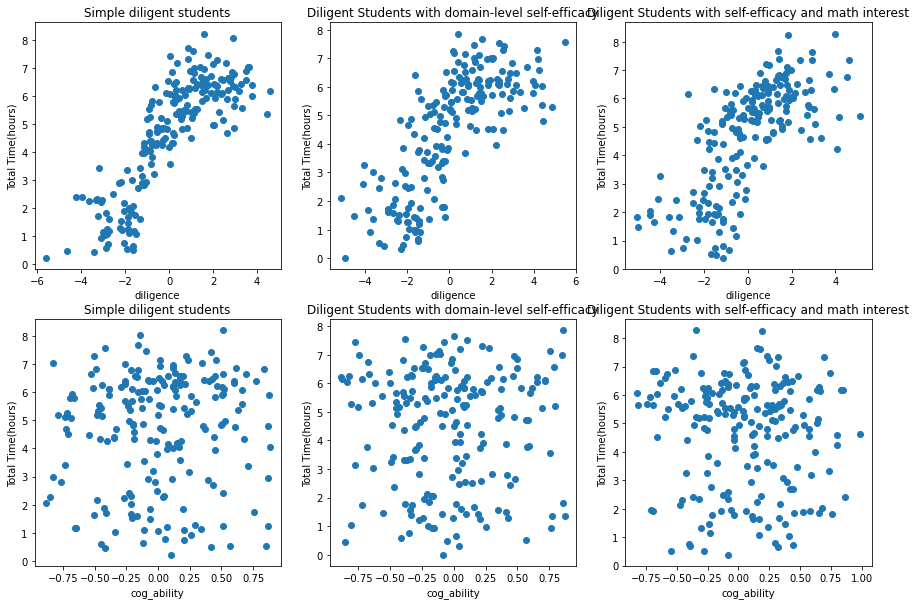

In [86]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "Total Time(hours)"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Diligence: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

##### M3: Time-on-task

INFO:analytics.batch:Comparing student sim: Simple diligent students
INFO:analytics.batch:R = 0.7522229205706386	 pval = 1.0056806350524975e-37
INFO:analytics.batch:Correlation with Cog Ability: R = 0.07240390097574553	 pval = 0.30826680109469756
INFO:analytics.batch:Comparing student sim: Diligent Students with domain-level self-efficacy
INFO:analytics.batch:R = 0.6691292259829558	 pval = 2.4980368665630035e-27
INFO:analytics.batch:Correlation with Cog Ability: R = -0.004727648054586917	 pval = 0.9470272586298424
INFO:analytics.batch:Comparing student sim: Diligent Students with self-efficacy and math interest
INFO:analytics.batch:R = 0.6093678563726415	 pval = 1.019726731577011e-21
INFO:analytics.batch:Correlation with Cog Ability: R = 0.005047850907192302	 pval = 0.9434452028297609


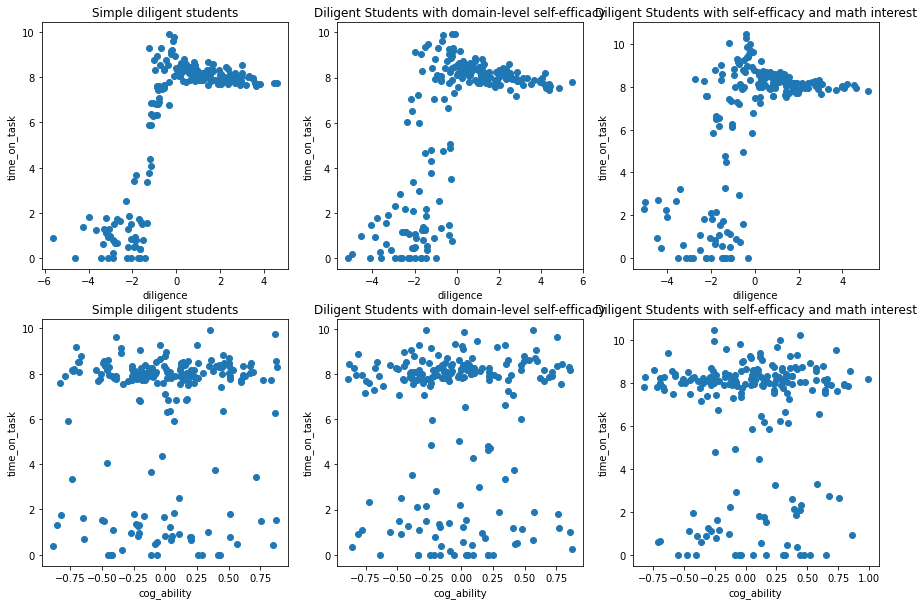

In [87]:
n = len(batch_descs)
plt.figure(figsize=(5*n,10))

for i, desc in enumerate(batch_descs):
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    xcol = "diligence"
    ycol = "time_on_task"
    X = ss[xcol]
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(2,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    
    xcol = "cog_ability"
    X = ss[xcol]
    corr, pval = pearsonr(X,Y)
    logger.info(f"Correlation with Cog Ability: R = {corr}\t pval = {pval}")

    plt.subplot(2,n,n+i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()
    
    

##### M4: Multi-Diligence Measures

INFO:analytics.batch:***************************************************
INFO:analytics.batch:Comparing student sim: Simple diligent students
INFO:analytics.batch:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.5903897351708653
INFO:analytics.batch:EigenValues: [2.43626676 0.45271426 0.11101897]
INFO:analytics.batch:Factor Loadings: [[-1.01536913]
 [ 0.73986822]
 [ 0.78503248]]
INFO:analytics.batch:Factor Variance: (array([2.19465545]), array([0.73155182]), array([0.73155182]))
INFO:analytics.batch:Factor loadings: Total Time(hours)     -1.015369
mean_detect_offtask    0.739868
mean_detect_guess      0.785032
dtype: float64
INFO:analytics.batch:(200,)
INFO:analytics.batch:******************* Pearson ********************
INFO:analytics.batch:R = -0.8400579828018815	 pval = 1.7316597401397453e-54
INFO:analytics.batch:***************************************************
INFO:analytics.batch:Comparing student sim: Diligent Students with domain-level self-efficacy
INFO:analytics.batch:Overall

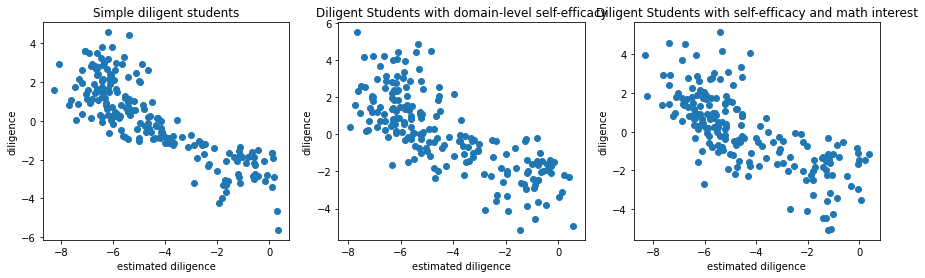

In [93]:
'''
Diligence Factors
    
    Time in system
    Frequency of Off-task
    P(guess)
    
'''
n = len(batch_descs)
plt.figure(figsize=(5*n,4))

for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']
    dil_cols = ['Total Time(hours)', 'mean_detect_offtask', 'mean_detect_guess']
    xcols= dil_cols
    ycol = "diligence"
    #Factor analysis
    df = ss.loc[:,xcols]
    kmo_all, kmo_model = calculate_kmo(df)
    logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
    fa = FactorAnalyzer(rotation=None,  n_factors=1)
    fa.fit(df)
    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    logger.info(f"EigenValues: {ev}")
    logger.info(f"Factor Loadings: {fa.loadings_}")
    logger.info(f"Factor Variance: {fa.get_factor_variance()}")
    
    loadings = pd.Series([x[0] for x in fa.loadings_], index=df.columns)
    logger.info(f"Factor loadings: {loadings}")
    X = df.mul(loadings).apply('sum', axis=1)
    logger.info(X.shape)
    Y = ss[ycol]
    corr, pval = pearsonr(X,Y)
    logger.info("******************* Pearson ********************")
    logger.info(f"R = {corr}\t pval = {pval}")

    plt.subplot(1,n,i+1)
    plt.scatter(X, Y)
    plt.title(desc)
    plt.xlabel("estimated diligence")
    plt.ylabel(ycol)
plt.show()



##### M5: Multiple Dil & Cog Measures

In [89]:
def identify_dil_factor(w, key_col="mean_detect_offtask"):
    abs_w = w.apply(lambda x: abs(x))
    return abs_w.idxmax(axis=1)[key_col]
    
def identify_nondil_factor(w, key_col="mean_detect_offtask"):
    abs_w = w.apply(lambda x: abs(x))
    idxmax = abs_w.idxmax(axis=1)[key_col]
    col = None
    for i, col in enumerate(w.columns):
        if i != idxmax:
            return i

    

INFO:analytics.batch:***************************************************
INFO:analytics.batch:Comparing student sim: Simple diligent students
INFO:analytics.batch:Overall Model Kaiser-Meyer-Olkin (KMO) Test: 0.7575796563139524
INFO:analytics.batch:EigenValues: [4.6129481  0.93665438 0.75598325 0.37158566 0.17682409 0.0945942
 0.05141032]
INFO:analytics.batch:Factor Loadings: [[ 0.92045457  0.38191983]
 [ 0.77146098  0.49903149]
 [ 0.75589379 -0.30111101]
 [ 0.44351866 -0.15680674]
 [ 0.91392174 -0.24898474]
 [-0.79866697  0.35321844]
 [-0.85049274 -0.0826438 ]]
INFO:analytics.batch:Factor Variance: (array([4.40693264, 0.70373805]), array([0.62956181, 0.10053401]), array([0.62956181, 0.73009581]))
INFO:analytics.batch:Factor loadings #0: accuracy                   0.920455
err_on_1_opp               0.771461
avg_prac_opp               0.755894
final-sim total mastery    0.443519
Total Time(hours)          0.913922
mean_detect_offtask       -0.798667
mean_detect_guess         -0.850493
N

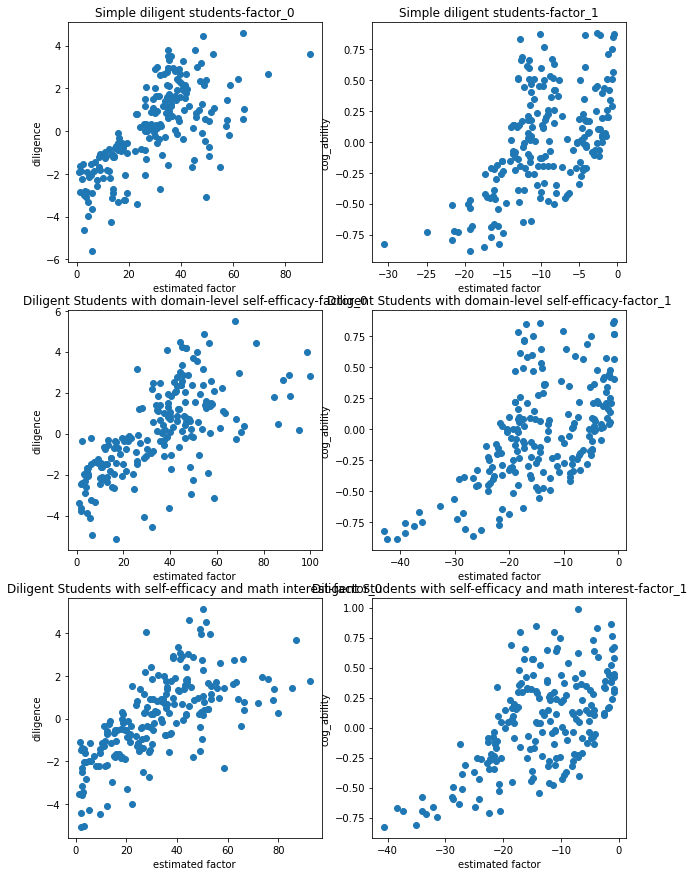

In [94]:
'''
Cognitive Factors
    Accuracy
    P(error | opp = 1) over all kc's
    E[P(mastery = k | kc)]
    Total Skills mastered
    
Diligence Factors
    
    Time in system
    Frequency of Off-task
    P(guess)
    
'''
n = len(batch_descs)
plt.figure(figsize=(10, 5*n))

for i, desc in enumerate(batch_descs):
    logger.info("***************************************************")
    logger.info(f"Comparing student sim: {desc}")
    ss = stu_stats[desc]
    cog_cols = ['accuracy', 'err_on_1_opp', 'avg_prac_opp', 'final-sim total mastery']
    # cog_cols = ['final-sim total mastery', 'err_on_1_opp']
    dil_cols = ['Total Time(hours)', 'mean_detect_offtask', 'mean_detect_guess']
    xcols= cog_cols + dil_cols
    ycol = "diligence"
    #Factor analysis
    df = ss.loc[:,xcols]
    kmo_all, kmo_model = calculate_kmo(df)
    logger.info(f"Overall Model Kaiser-Meyer-Olkin (KMO) Test: {kmo_model}")
    fa = FactorAnalyzer(rotation=None,  n_factors=2)
    fa.fit(df)
    # Check Eigenvalues
    ev, v = fa.get_eigenvalues()
    logger.info(f"EigenValues: {ev}")
    logger.info(f"Factor Loadings: {fa.loadings_}")
    logger.info(f"Factor Variance: {fa.get_factor_variance()}")
    
    all_loadings = pd.DataFrame(fa.loadings_, index=df.columns)
    dil_col = identify_dil_factor(all_loadings)

    for j, col in enumerate(all_loadings.columns):
        loadings = all_loadings.loc[:,col]
        logger.info(f"Factor loadings #{i}: {loadings}")
        X = df.mul(loadings).apply('sum', axis=1)
        logger.info(X.shape)
        if j == dil_col:
            ycol = 'diligence'
        else:
            ycol = "cog_ability"
        Y = ss[ycol]
        corr, pval = pearsonr(X,Y)
        logger.info(f"******************* Pearson with {ycol} ********************")
        logger.info(f"R = {corr}\t pval = {pval}")

        plt.subplot(n,2,(2*i) + j+1)
        plt.scatter(X, Y)
        plt.title(f"{desc}-factor_{col}")
        plt.xlabel("estimated factor")
        plt.ylabel(ycol)
plt.show()



##### M6: Multiple Dil & Cog Measures + CAE 

In [ ]:
Notes:
    
    - Could use AFM to estimate initial cog ability
    - Consider other confounders (self-eff or math-int) other than cog_ability
    -- Useful to show strenght of correlation with factor and ability of method to differentiate confounds